# Crime Centroids

 Find crime centroids using data from https://data.police.uk/data/ to find areas of higher crime with the aim of finding new patrol stops or locations.

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import glob

Data is obtained as seperate .csv files for different months. This part of the code combines the seperate .csv files into one pandas dataframe and displays the first 5 entries. 

For the purposes of the notebook I'm using the data from 06-2023 to 01-2024.

In [2]:
file_paths = glob.glob('Metropolitan/*.csv')
seperate_dfs = [pd.read_csv(file) for file in file_paths]
df = pd.concat(seperate_dfs, ignore_index=True)
df.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,a5a2ab72258bfb2e808347707bcc312470d031825e0911...,2023-06,Metropolitan Police Service,Metropolitan Police Service,-0.685028,50.780596,On or near Park Road,E01031437,Arun 017E,Violence and sexual offences,Status update unavailable,NaN
1,16efc0a615f7368d0d34c82d9989a1eb485616f8bc56d3...,2023-06,Metropolitan Police Service,Metropolitan Police Service,-0.686514,50.780694,On or near Stocker Road,E01031437,Arun 017E,Violence and sexual offences,Status update unavailable,NaN
2,8400c77980478215c845adbe62aae9b205385268ca8b4a...,2023-06,Metropolitan Police Service,Metropolitan Police Service,0.876053,51.171725,On or near Hereford Close,E01032810,Ashford 001F,Violence and sexual offences,Investigation complete; no suspect identified,NaN
3,f087d98aff683f2a8e59de5cf0ae87c876dd77794fd804...,2023-06,Metropolitan Police Service,Metropolitan Police Service,0.870748,51.148056,On or near Bank Street,E01034986,Ashford 005G,Violence and sexual offences,Status update unavailable,NaN
4,NaN,2023-06,Metropolitan Police Service,Metropolitan Police Service,0.140194,51.582356,On or near Hatch Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN


Dataframes shape

In [3]:
df.shape

(779670, 12)

The column names of the dataframe

In [4]:
df.columns

Index(['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude',
       'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type',
       'Last outcome category', 'Context'],
      dtype='object')

Display the unique values that crimes are assigned.

In [5]:
print(df["Crime type"].unique())

['Violence and sexual offences' 'Anti-social behaviour' 'Burglary'
 'Public order' 'Vehicle crime' 'Criminal damage and arson' 'Drugs'
 'Possession of weapons' 'Other theft' 'Robbery' 'Theft from the person'
 'Other crime' 'Shoplifting' 'Bicycle theft']


Checking the data set for missing values.

In [6]:
df.isna().sum()

Crime ID                 156084
Month                         0
Reported by                   0
Falls within                  0
Longitude                 13571
Latitude                  13571
Location                      0
LSOA code                 13571
LSOA name                 13571
Crime type                    0
Last outcome category    156084
Context                  779670
dtype: int64

In [7]:
whole = df.shape[0]
missing = df["Longitude"].isna().sum()
print(f"Percentage missing: {round((missing/whole)*100,2)}%")

Percentage missing: 1.74%


Showing the total nan values for the data frame shows that roughly 1.7 percent of the values for the longitude and latitude are missing. While not ideal this amount is relatively small and shouldn't have an affect on the results for the model.

In [16]:
crimes = df["Crime type"].unique()

#################################################################################
crime_index = 13 #Change the number here to change the crime being looked at 0-13
#################################################################################

print(f"Searching for: {crimes[crime_index]}")
df_filtered = df[df["Crime type"] == crimes[crime_index]] 
print(f"Cases found: {df_filtered.shape[0]}")

Searching for: Bicycle theft
Cases found: 11300


### Plot the locations of the crimes

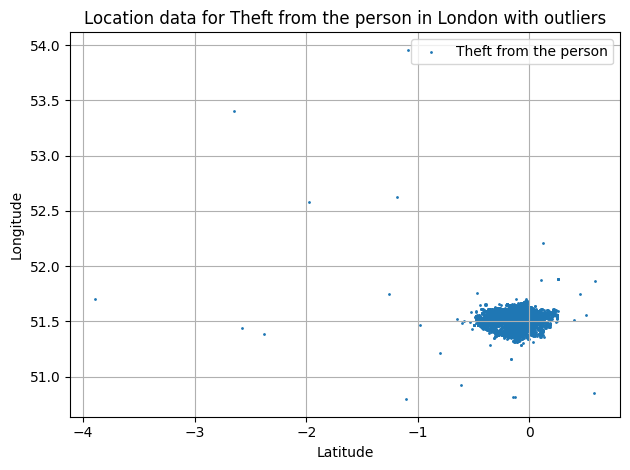

In [9]:
plt.title(f"Location data for {crimes[crime_index]} in London with outliers")
plt.scatter(df_filtered["Longitude"],df_filtered["Latitude"], s=1, alpha=1, label=crimes[crime_index])
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

This plot has revealed some strong outliers in the location data. When I looked in to this it is related to when a crime is commnited in one area but the arrest is made in antoher. All of the crimes in this dataset are dealt with by the Metropolitan Police Service but the arrest could be made in another area. Due to the small amount of outliers I am comfortable to remove them from the dataset so they don't skew any of the centroids later.

In [10]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_cleaned_lat = remove_outliers(df_filtered, 'Latitude')
df_cleaned = remove_outliers(df_cleaned_lat, 'Longitude')

print(df_filtered.shape)
print(df_cleaned.shape)

(51656, 12)
(37180, 12)


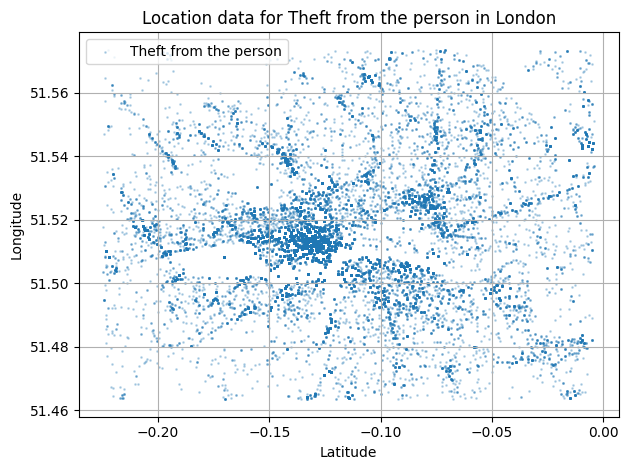

In [11]:
plt.title(f"Location data for {crimes[crime_index]} in London")
plt.scatter(df_cleaned["Longitude"],df_cleaned["Latitude"], s=1, alpha=0.25, label=crimes[crime_index])
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

Above shows the data with the location outliers removed and the alpha lowered on the dots to better show any high density areas.

### Time to train a clustering model

Imports

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans, MiniBatchKMeans

Define the data for the model and store it as a numpy array.

In [13]:
X = df_cleaned[["Longitude","Latitude"]].values

Time to create an elbow plot to find out the optimal number of clusters. 

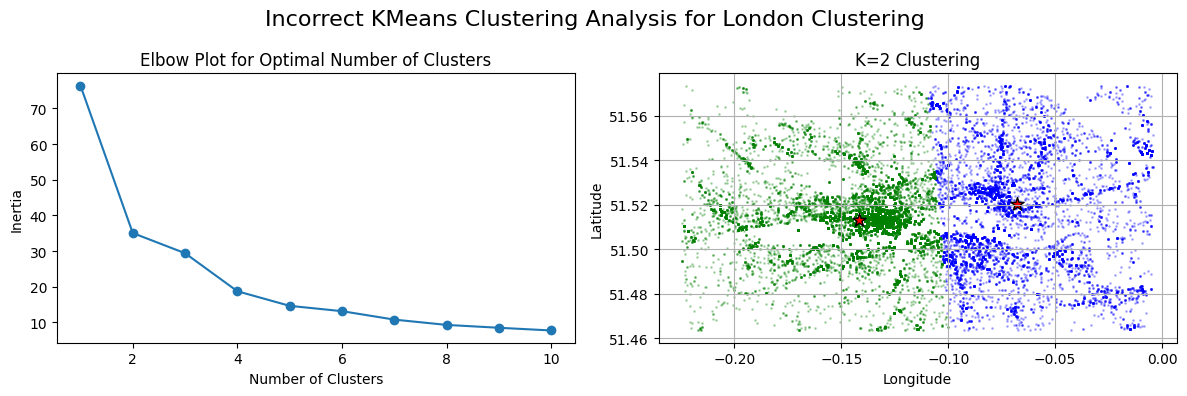

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

range_n_clusters = list(range(1, 11))

# List to store the inertia values
inertia = []

# Fit the KMeans algorithm for each number of clusters and store the inertia
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    
# Plot the inertia values to create the elbow plot
ax1.plot(range_n_clusters, inertia, marker='o')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Plot for Optimal Number of Clusters')
   
clusters = 2
km =KMeans(n_clusters =clusters,
          init="random",
          n_init=10,
          max_iter=300,
          tol=1e-04,
          random_state=0)
y_km = km.fit_predict(X)

colors =["blue", "green"]

for i in range(clusters):
    ax2.scatter(X[y_km == i,0],
                X[y_km == i,1],
               s=1, c = colors[i],
               alpha=0.25, label=f"Cluster {i+1}")
ax2.scatter(km.cluster_centers_[:,0],
           km.cluster_centers_[:,1],
           s=100, marker="*",
           c="red", edgecolor="black",
           label="Centroids")

ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title('K=2 Clustering')

fig.suptitle('Incorrect KMeans Clustering Analysis for London Clustering', fontsize=16)

plt.grid()
plt.tight_layout()
plt.show()

The elbow plot suggests just two clusters for the whole of London. This is obvioulsy not a good fit for the goal of finding new monitoring or patrol stops so I'm going to find another solution. One way of increasing the number of clusters would be to manually chose an number. For a non-hypothecial implientation like I am doing here this could be linked to the number of stops funding would allow. For this example I will arbitrarily chose 15. (The reader can easily change this value if you wish)

Text(0.5, 1.0, 'K=15 Clustering to show Bicycle theft in London')

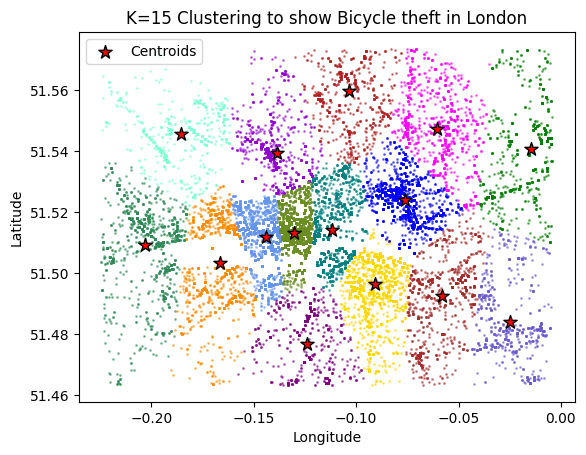

In [18]:
###################################################
hypothecial_clusters = 15 #Encouraged to be changed 
###################################################

km =KMeans(n_clusters = hypothecial_clusters,
          init="random",
          n_init=10,
          max_iter=300,
          tol=1e-04,
          random_state=0)
y_km = km.fit_predict(X)

colors =["blue", "green", "brown", "teal", "magenta", "purple", "gold", "firebrick", "darkorange", "cornflowerblue", "darkviolet", "aquamarine", "seagreen", "slateblue", "olivedrab"]

for i in range(hypothecial_clusters):
    plt.scatter(X[y_km == i,0],
                X[y_km == i,1],
               s=1, c = colors[i],
               alpha=0.5)
plt.scatter(km.cluster_centers_[:,0],
           km.cluster_centers_[:,1],
           s=100, marker="*",
           c="red", edgecolor="black",
           label="Centroids")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title(f'K={hypothecial_clusters} Clustering to show {crimes[crime_index]} in London')


### Note:
The crime index number and number of clusters are defined as variables to make changing them easyly done and is encouraged to be changed if you want to see different values.

## Conclusion 

The analysis focused on identifying clusters of bike thefts in London using KMeans clustering. The dataset, sourced from police records, was compiled from several monthly CSV files and then cleaned to remove missing values, particularly for the longitude and latitude coordinates.

Initial visualizations of the data revealed significant outliers, which were addressed to ensure more accurate clustering results. The elbow method was applied to determine the optimal number of clusters, suggesting that two clusters might be suitable for the entire dataset. However, this was not practical for identifying specific patrol stops within London due to the city's size and wide area in crime distribution.

To provide a more detailed analysis, I arbitrarily chose 15 clusters to reflect a more granular division of the city. The KMeans clustering with this configuration produced clusters that better represented localized areas with higher incidences of bike theft. This clustering approach is more useful for practical applications such as determining new patrol stops or targeted monitoring areas.

In conclusion, the clustering analysis revealed that a higher number of clusters is necessary to meaningfully segment London for the purpose of crime prevention and resource allocation. Future work could refine this approach by integrating additional data sources or adjusting the number of clusters based on specific criteria like available resources or crime rates in different boroughs.